In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import copy
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn.functional as F
from sklearn import decomposition
from sklearn import manifold
import random
import time

In [2]:
print(torch.__version__)

1.8.1


In [3]:
!python3 -V

Python 3.8.8


# Helpers

In [4]:
original_model = './VGG/vgg16_mnist.pth'
original_models_plot_img = './VGG/vgg16_mnist.png'
improved_model = './VGG/vgg_new16_mnist.pth'
improved_models_plot_img = './VGG/vgg16_improv_mnist.png'
data_dir = '../CV_Data'

## General

In [5]:

batch_size=128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
def normalize_data(train_set,three_channels=False):
    print(train_set.data.shape)
    mean, std = train_set.data.float().mean()/255, train_set.data.float().std()/255
    print('Mean:', mean)
    print('Std: ', std)
    return transforms.Normalize(mean=(mean.item(),),std=(std.item(),))

In [8]:
def save_model(model, path):
  torch.save(model.state_dict(), path)

In [9]:
def load_model(model, path):
  model.load_state_dict(torch.load(path))

## Dataset

In [10]:
def load_mnist(train_transforms, val_test_transforms):
    download = False
    if os.path.isdir(data_dir + '/' + 'MNIST') == False:
      download = True

    train_data = datasets.MNIST(root=data_dir, train=True, download=download, transform=train_transforms)
    test_data = datasets.MNIST(root=data_dir, train=False, download=download, transform=val_test_transforms)
    print("Training dataset:", train_data)
    print("Test dataset:", test_data)
    return train_data, test_data

In [11]:
def get_classes(dataset):
    return dataset.classes

In [12]:
def get_train_val_sets(train_data):
    train_set, val_set = torch.utils.data.random_split(train_data, [50000, 10000])
    return train_set, val_set

## Visualization

In [13]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

### Visualize images with classes

In [14]:
def visualize_images_from_dataset(dataset):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

In [15]:
def visualize_images_from_loader(loader):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3

    train_features, train_labels = next(iter(loader))

    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    for i in range(1,10):
      img = train_features[i].squeeze()
      label = train_labels[i]
      figure.add_subplot(rows, cols, i)
      plt.title(label.item())
      plt.axis("off")
      plt.imshow(img, cmap="gray")
    plt.show()

In [16]:
def get_10_sample_of_the_same_class(class_name, dataset):
    sample = []
    while len(sample) < 10:
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        if classes[label] == class_name:
            sample.append((img,label))
    return sample

In [17]:
def plot_sample_same_class(class_name, dataset):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    
    sample = get_10_sample_of_the_same_class(class_name, dataset)
    for i in range(1, cols * rows + 1):
        img, label = sample[i]
        figure.add_subplot(rows, cols, i)
        plt.title(classes[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

### Metrics

In [18]:
def plot_results(e, h, info, name):
    epochs_range = [i for i in range(e)]

    fig, (loss_plot, acc_plot) = plt.subplots(1, 2, figsize =(12,4))

    loss_plot.plot(epochs_range, h['train_loss'], color='red', label='train loss')
    loss_plot.plot(epochs_range, h['val_loss'], color='green', label='val loss')
    loss_plot.set_title('Epochs - Loss | {}'.format(info))
    loss_plot.legend()

    acc_plot.plot(epochs_range, h['train_acc'], color='red', label='train acc')
    acc_plot.plot(epochs_range, h['val_acc'], color='green', label='val acc')
    acc_plot.set_title('Epochs - Accuracy | {}'.format(info))
    acc_plot.legend()
    plt.savefig(name)
    plt.show()

In [19]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    conf_matrix = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(conf_matrix, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    return conf_matrix

In [20]:
def get_accuracy_for_specific_labels(class_label,conf_matrix):
  position_in_dict = np.argmax(conf_matrix[class_label])
  return np.sum(conf_matrix.diagonal()[position_in_dict]/np.sum(conf_matrix[position_in_dict]))

In [21]:
def show_per_class_accuracies():
    per_class_accuracies = []
    for idx,c in enumerate(classes):
        class_acc = get_accuracy_for_specific_labels(idx,cm)
        print(c + " class accuracy:", class_acc*100)
        per_class_accuracies.append((class_acc,idx))
    return per_class_accuracies

### Incorrect Examples

In [22]:
def get_incorrect_examples(cm, per_class_accuracies):
    five_top_incorrect_classes = sorted(per_class_accuracies, key=lambda acc: acc[0])[:5]
    img_labels_preds_idx = []
    for acc,idx in five_top_incorrect_classes:
        for i in [item for item in np.where(labels == idx)[0] if item not in np.where(pred_labels == idx)[0]]:
            img_labels_preds_idx.append((images[i],test_data.targets[i],pred_labels[i], idx))
    return img_labels_preds_idx     

In [23]:
def plot_incorrect_examples_from_top5_classes(n_images, confusion_matrix, per_class_accuracies, normalize=True):  
    fig = plt.figure(figsize = (16, 16))
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    incorrect_examples = get_incorrect_examples(confusion_matrix, per_class_accuracies)
    for i in range(rows*cols):
        sample_idx = random.randint(0, len(incorrect_examples))
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, false_label,idx = incorrect_examples[sample_idx]
        image = image.squeeze()
        true_class = true_label.numpy().astype(str)
        incorrect_class = false_label.numpy()[0].astype(str)
        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy(),cmap="gray")
        ax.set_title(f'true label: {true_class} \n' \
                         f'pred label: {incorrect_class} ')
        ax.axis('off')

    fig.subplots_adjust(hspace = 0.4)

### PCA

In [24]:
def get_representations(model, iterator):
    model.eval()
    outputs = []
    intermediates = []
    labels = []
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [25]:
def get_pca(data):
    pca = decomposition.PCA()
    pca.n_components = 2
    pca_data = pca.fit_transform(data)
    return pca_data

In [26]:
def plot_representations(data, labels, classes, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

## Training-Test Helpers

In [27]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)
        
        # compute output and loss
        output = model(data)
        loss = criterion(output, target)

        # backward and update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(target.data.view_as(pred)).cpu().sum()

        train_correct += correct
        train_loss += loss.data.item()

        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data.item()))
    
    # Get training epoch loss and accuracy
    train_loss /= len(train_loader.dataset)
    epoch_acc = float(train_correct) / len(train_loader.dataset)
    print('\nOn Training set Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)'.format(
      train_loss, train_correct, len(train_loader.dataset),
      100.0 * epoch_acc))
    return train_loss, epoch_acc

In [28]:
def validate(val_loader, model, criterion):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
      for _, (data, target) in enumerate(val_loader):
          data = data.to(device)
          target = target.to(device)
          
          output = model(data)
          
          loss += criterion(output, target).data.item()

          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()
          
      loss /= len(val_loader.dataset)
      epoch_acc = float(correct) / len(val_loader.dataset)
      print('On Val set Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
          loss, correct, len(val_loader.dataset),
          100.0 * epoch_acc))
    return loss,epoch_acc

In [29]:
def get_predictions(model, test_loader):
    model.eval()
    images = []
    labels = []
    probs = []
    correct = 0
    with torch.no_grad():
    
        for _, (data, target) in enumerate(test_loader):
          data = data.to(device)
          target = target.to(device)

          data = data.to(device)
          target = target.to(device)
          
          output = model(data)
          
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

          images.append(data.cpu())
          labels.append(target.cpu())
          probs.append(pred.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    acc = float(correct) / len(val_loader.dataset)
    print('\nOn Test set Accuracy: {}/{} ({:.3f}%)\n'.format(
      correct, len(test_loader.dataset),
      100.0 * acc))
    return images, labels, probs

In [30]:
def fit_model(model, num_epochs, train_loader, val_loader, optimizer, criterion, lr_scheduler = None):

  best_acc = 0.0
  hist = { "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "per_epoch_time": [] }
  start_time = time.time()
  for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    if lr_scheduler != None:
      print("\nTrain Epoch {}: ".format(epoch))
      print("Current learning rate: {}".format(lr_scheduler.get_last_lr()))
    else:
      print("\nTrain Epoch {}: ".format(epoch))
      print("Learning rate: {}".format(optimizer.param_groups[0]['lr']))

    epoch_train_loss, epoch_train_acc = train(train_loader, model, criterion, optimizer, epoch)
    epoch_val_loss, epoch_val_acc = validate(val_loader, model, criterion)
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        print("New best Validation accuracy ({:.3f}%) achieved so far! \n".format(100.0 * best_acc))


    # Store acuracy and loss scores for current epoch
    hist['train_acc'].append(epoch_train_acc)
    hist['train_loss'].append(epoch_train_loss)
    hist['val_acc'].append(epoch_val_acc)
    hist['val_loss'].append(epoch_val_loss)

    if lr_scheduler != None:
      lr_scheduler.step()

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print("Epoch %d of %d with %.2f s" % (epoch, epochs, per_epoch_ptime))
    hist["per_epoch_time"].append(per_epoch_ptime)
    
  training_time = time.time() - start_time
  print('\nModel fit in : {:.2f}s'.format(training_time))
  

  return model, hist

# VGG16 - Original implemenation from Pytorch




In [31]:
vgg = torchvision.models.vgg16(pretrained=False)

In [32]:
print(f'The model has {count_parameters(vgg):,} trainable parameters')

The model has 138,357,544 trainable parameters


# MNIST

Since MNIST classes are 10 and not 1000 like Image Net, the last dense layer needs to output 10 features instead of 1000

In [33]:
final_layer = nn.Linear(vgg.classifier[-1].in_features , 10)
vgg.classifier[-1] = final_layer

To be able to use our net in the MNIST dataset we need our first layer(i.e Conv2d) to receive single channel inputs.

In [34]:
new_cnn = nn.Conv2d(1, 64, (3,3), stride=1, padding=1)
vgg.features[0] = new_cnn

In [35]:
vgg = vgg.to(device)

In [36]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [37]:
train_transforms = transforms.Compose(
    [
      transforms.Resize(64), # resize images to 64 x 64
      transforms.ToTensor()
    ])

val_test_transforms = transforms.Compose(
    [
     transforms.Resize(64),
     transforms.ToTensor()
    ])

In [38]:
train_data, test_data = load_mnist(train_transforms, val_test_transforms)

Training dataset: Dataset MNIST
    Number of datapoints: 60000
    Root location: ../CV_Data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor()
           )
Test dataset: Dataset MNIST
    Number of datapoints: 10000
    Root location: ../CV_Data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor()
           )


In [39]:
transforms_normalize = normalize_data(train_data)
transforms_normalize

torch.Size([60000, 28, 28])
Mean: tensor(0.1307)
Std:  tensor(0.3081)


Normalize(mean=(0.13066048920154572,), std=(0.30810779333114624,))

Based on the values per channel (mean,std) we want to normalize the data accordingly, therefore we reload the data with the appropriate transformation

In [40]:
train_transforms.transforms.insert(2, transforms_normalize)

The same is applied to the validation and test transformations

In [41]:
val_test_transforms.transforms.insert(2, transforms_normalize)

Reload the data with the normalization transformation

In [42]:
train_data, test_data = load_mnist(train_transforms, val_test_transforms)

Training dataset: Dataset MNIST
    Number of datapoints: 60000
    Root location: ../CV_Data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.13066048920154572,), std=(0.30810779333114624,))
           )
Test dataset: Dataset MNIST
    Number of datapoints: 10000
    Root location: ../CV_Data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.13066048920154572,), std=(0.30810779333114624,))
           )


In [43]:
classes = get_classes(test_data)
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## Split into training 

In [44]:
train_set, val_set = get_train_val_sets(train_data)

The validation set needs to be transformed with the transfomer used for the test dataset

In [45]:
import copy
val_set = copy.deepcopy(val_set)
val_set.dataset.transform = val_test_transforms

In [46]:
val_test_transforms.transforms

[Resize(size=64, interpolation=bilinear),
 ToTensor(),
 Normalize(mean=(0.13066048920154572,), std=(0.30810779333114624,))]

Finally, the loaders can be created

In [47]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

## Initial Visualization

Number of training examples: 50000
Number of validation examples: 10000
Number of testing examples: 10000
Feature batch shape: torch.Size([128, 1, 64, 64])
Labels batch shape: torch.Size([128])


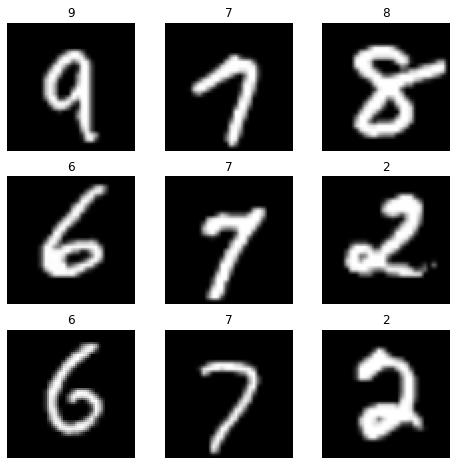

In [48]:
print(f'Number of training examples: {len(train_set)}')
print(f'Number of validation examples: {len(val_set)}')
print(f'Number of testing examples: {len(test_data)}')
visualize_images_from_loader(train_loader)

## Train the vgg16 original implemenation

In [ ]:
epochs = 50
# step_size = 5    
base_lr = 0.001    

optimizer = torch.optim.SGD(vgg.parameters(), lr=base_lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
vgg, hist = fit_model(
    model = vgg, 
    num_epochs = epochs, 
    train_loader = train_loader, 
    val_loader = val_loader,
    optimizer = optimizer,
    criterion = loss_fn,
    lr_scheduler = None
  )


Train Epoch 1: 
Learning rate: 0.001
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.545147
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.252757
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.273544

On Training set Average loss: 0.0046, Accuracy: 39886/50000 (79.772%)
On Val set Average loss: 0.0008, Accuracy: 9682/10000 (96.820%)

New best Validation accuracy (96.820%) achieved so far! 

Epoch 1 of 50 with 64.26 s

Train Epoch 2: 
Learning rate: 0.001
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.145863
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.102423
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.149934

On Training set Average loss: 0.0008, Accuracy: 48360/50000 (96.720%)
On Val set Average loss: 0.0006, Accuracy: 9752/10000 (97.520%)

New best Validation accuracy (97.520%) achieved so far! 

Epoch 2 of 50 with 64.24 s

Train Epoch 3: 
Learning rate: 0.001
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.120611
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.151457
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.0

In [ ]:
# torch.save(vgg.state_dict(), 'vgg16_model_weights.pth')

In [ ]:
save_model(vgg, original_model)

In [ ]:
images, labels, pred_labels = get_predictions(vgg, test_loader)


On Test set Accuracy: 9919/10000 (99.190%)



# Visualization after training

## Loss and Accuracy Plots

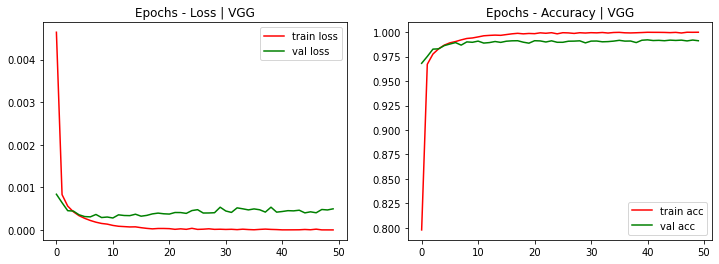

In [ ]:
plot_results(epochs, hist, info='VGG', name=original_models_plot_img)

## Confusion Matrix

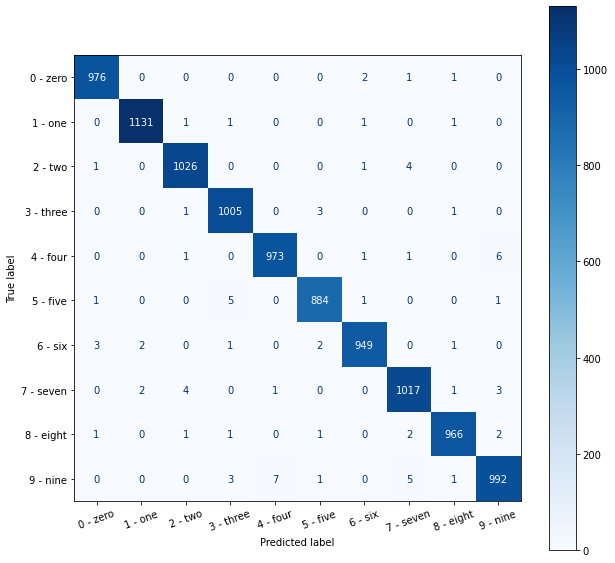

In [ ]:
cm = plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
per_class_accuracies = show_per_class_accuracies()

0 - zero class accuracy: 99.59183673469387
1 - one class accuracy: 99.64757709251101
2 - two class accuracy: 99.4186046511628
3 - three class accuracy: 99.5049504950495
4 - four class accuracy: 99.08350305498982
5 - five class accuracy: 99.10313901345292
6 - six class accuracy: 99.06054279749478
7 - seven class accuracy: 98.92996108949417
8 - eight class accuracy: 99.17864476386036
9 - nine class accuracy: 98.31516352824579


## PCA

In [ ]:
outputs, labels = get_representations(vgg, test_loader)

In [ ]:
outputs[:1]

tensor([[ -3.5874,   2.7274,  -2.0037,  -1.4572,   3.8736,  -5.8637, -19.0365,
          34.9173,  -9.1988,   1.2577]])

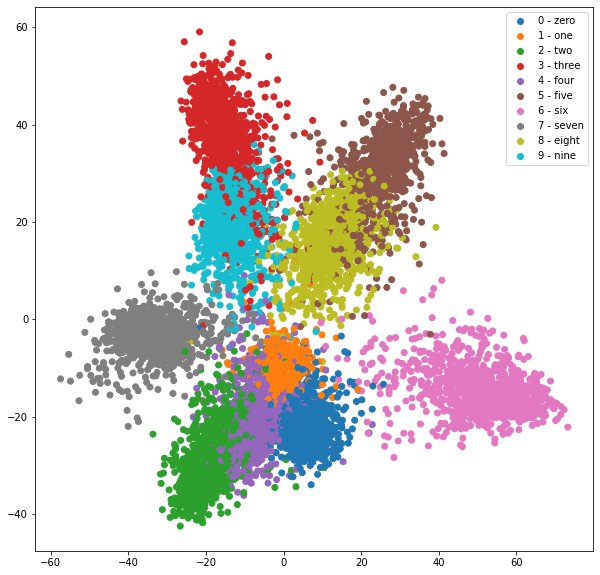

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

# Improvements

We visualize images belonging to the same class to apply the approriate transformations to the training dataset 

These transformations can improve the accuracy of the model as well as its generalization to new data

In [49]:
print('Uncomment the following lines to take a look at a grid of 6x6 images belonging to each class')
# for c in classes:
#     plot_sample_same_class(c, train_data) 

Uncomment the following lines to take a look at a grid of 6x6 images belonging to each class


## Pytorch Transformations

After taking a look on the images for each classimport torchvision.transforms.functional as TF
import random

In [50]:
train_transforms = transforms.Compose(
    [
      transforms.Resize(64), # resize images to 64 x 64
      transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.8,1.2)), #
      transforms.ToTensor(),
    transforms_normalize
    ])
val_test_transforms = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms_normalize
    ])

In [51]:
train_data, test_data = load_mnist(train_transforms, val_test_transforms)

Training dataset: Dataset MNIST
    Number of datapoints: 60000
    Root location: ../CV_Data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               RandomAffine(degrees=[-15.0, 15.0], translate=(0.1, 0.1), scale=(0.8, 1.2))
               ToTensor()
               Normalize(mean=(0.13066048920154572,), std=(0.30810779333114624,))
           )
Test dataset: Dataset MNIST
    Number of datapoints: 10000
    Root location: ../CV_Data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.13066048920154572,), std=(0.30810779333114624,))
           )


In [52]:
train_set, val_set = get_train_val_sets(train_data)
val_set = copy.deepcopy(val_set)
val_set.dataset.transform = val_test_transforms

In [53]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

## Visualization of the Data after Augmentation

Feature batch shape: torch.Size([128, 1, 64, 64])
Labels batch shape: torch.Size([128])


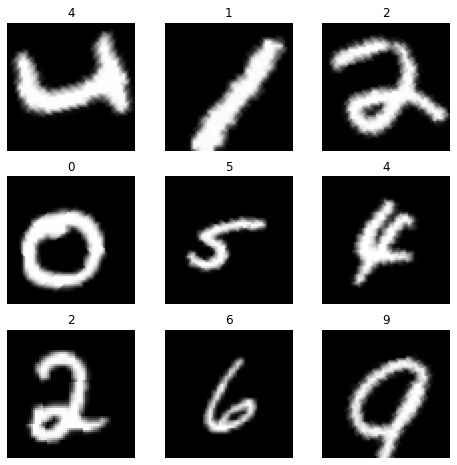

In [ ]:
visualize_images_from_loader(train_loader)

## Model's Architecture -- VGG with Batch Normalization

In [ ]:
cfg = {
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG16_new': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
}

**Changes from the original implementation**:

*   **Added** batch Normalization layers to the original VGG architecture. Batch normalization layers' functionality will be further discussed in the report.
*   **Changed** AdaptiveAvgPool2d layer with an AdaptiveMaxPool2d one.
*   **Changed** the output size of the AdaptiveMaxPool2d layer to (5,5), hence decreasing model parameters by ~38%
*   **Initialized** the weights and biases of the layers from the appropriate distributions 



In [ ]:
class VGG(nn.Module):
    def __init__(self, vgg_name, num_classes, use_bn):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name],use_bn)
        self.avgpool = nn.AdaptiveMaxPool2d((5, 5))
        self.classifier = self._create_classifer(num_classes)
        self._initialize_weights()
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _create_classifer(self,num_classes):
        return nn.Sequential(
            nn.Linear(512 * 5 * 5, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def _initialize_weights(self) -> None:
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)

    def _make_layers(self, cfg, use_bn):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
              if use_bn:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                            nn.BatchNorm2d(x), # added batch normalizaiton layers
                            nn.ReLU(inplace=True)]
              else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)]


              in_channels = x

        return nn.Sequential(*layers)

The output of the VGG-net was decreased to 10 features since both MNIST and CIFAR10 contain 10 classes.

In [ ]:
vgg_new16 = VGG('VGG16_new',10, True)
new_cnn = nn.Conv2d(1, 64, (3,3), stride=1, padding=1)
vgg_new16.features[0] = new_cnn
vgg_new16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
print(f'The model has {count_parameters(vgg_new16):,} trainable parameters')

The model has 83,977,162 trainable parameters


In [ ]:
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, smoothing: float = 0.1, 
                 reduction="mean", weight=None):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing   = smoothing
        self.reduction = reduction
        self.weight    = weight

    def reduce_loss(self, loss):
        return loss.mean() if self.reduction == 'mean' else loss.sum() \
         if self.reduction == 'sum' else loss

    def linear_combination(self, x, y):
        return self.smoothing * x + (1 - self.smoothing) * y

    def forward(self, preds, target):
        assert 0 <= self.smoothing < 1

        if self.weight is not None:
            self.weight = self.weight.to(preds.device)

        n = preds.size(-1)
        log_preds = F.log_softmax(preds, dim=-1)
        loss = self.reduce_loss(-log_preds.sum(dim=-1))
        nll = F.nll_loss(
            log_preds, target, reduction=self.reduction, weight=self.weight
        )
        return self.linear_combination(loss / n, nll)

## Train the new vgg16 

I also used a multi step learning rate scheduler to decrease the learning rate after certain epochs

In [ ]:
epochs = 50    
base_lr = 0.01
learning_rate_decay = 0.1    

optimizer = torch.optim.SGD(vgg_new16.parameters(), lr=base_lr, momentum=0.9)
# loss_fn = nn.CrossEntropyLoss()
loss_fn = LabelSmoothingLoss(smoothing = 0.1, reduction="mean")

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,27,40,47], gamma=learning_rate_decay)

In [ ]:
vgg_new16, hist = fit_model(
    model = vgg_new16, 
    num_epochs = epochs, 
    train_loader = train_loader, 
    val_loader = val_loader,
    optimizer = optimizer,
    criterion = loss_fn,
    lr_scheduler = lr_scheduler
  )


Train Epoch 1: 
Current learning rate: [0.01]
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.680554
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.591747
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.620157

On Training set Average loss: 0.0061, Accuracy: 45092/50000 (90.184%)
On Val set Average loss: 0.0046, Accuracy: 9763/10000 (97.630%)

New best Validation accuracy (97.630%) achieved so far! 

Epoch 1 of 50 with 94.95 s

Train Epoch 2: 
Current learning rate: [0.01]
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.588065
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.556615
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.560105

On Training set Average loss: 0.0044, Accuracy: 49248/50000 (98.496%)
On Val set Average loss: 0.0042, Accuracy: 9911/10000 (99.110%)

New best Validation accuracy (99.110%) achieved so far! 

Epoch 2 of 50 with 97.32 s

Train Epoch 3: 
Current learning rate: [0.01]
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.578361
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.548058
Train Epoch: 3 [3

In [ ]:
# torch.save(vgg_new16.state_dict(), 'vgg_new16_mnist.pth')

In [ ]:
# load_model(vgg_new16, 'vgg_new16_mnist.pth')

In [ ]:
save_model(vgg_new16, improved_model)

In [ ]:
images, labels, pred_labels = get_predictions(vgg_new16, test_loader)


On Test set Accuracy: 9965/10000 (99.650%)



In [ ]:
# images, labels, pred_labels = get_predictions(vgg_new16, test_loader)

## Visualization after training

In [ ]:
classes = get_classes(test_data)

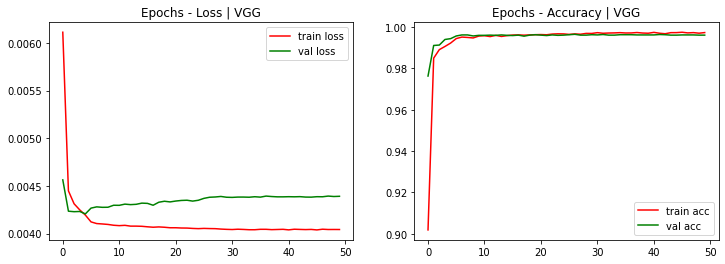

In [ ]:
plot_results(epochs, hist, info='VGG', name=improved_models_plot_img)

### Confusion matrix

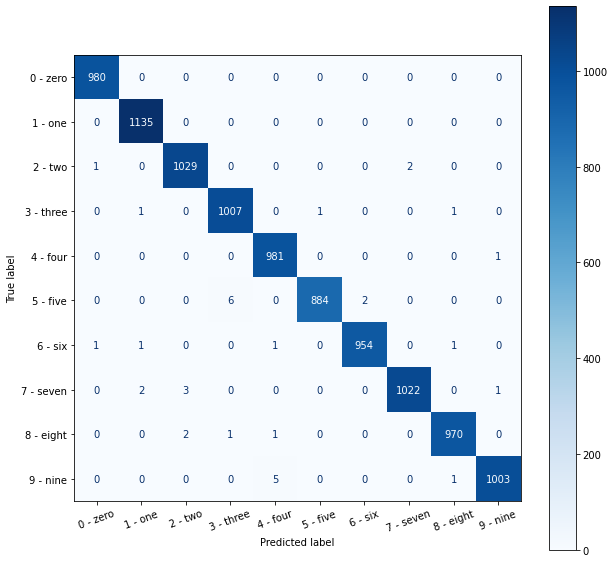

In [ ]:
cm = plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
per_class_accuracies = show_per_class_accuracies()

0 - zero class accuracy: 100.0
1 - one class accuracy: 100.0
2 - two class accuracy: 99.70930232558139
3 - three class accuracy: 99.70297029702971
4 - four class accuracy: 99.89816700610999
5 - five class accuracy: 99.10313901345292
6 - six class accuracy: 99.58246346555325
7 - seven class accuracy: 99.41634241245137
8 - eight class accuracy: 99.58932238193019
9 - nine class accuracy: 99.40535183349851


### Incorrect Examples

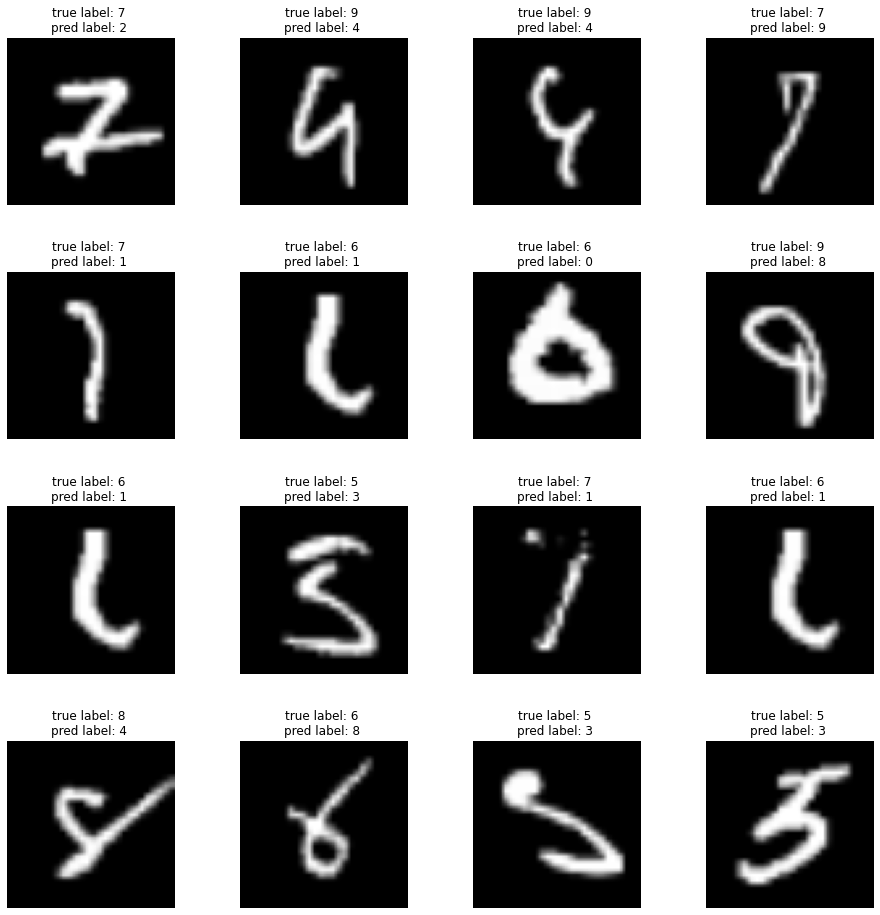

In [ ]:
plot_incorrect_examples_from_top5_classes(16,cm, per_class_accuracies)

### PCA

In [ ]:
outputs, labels = get_representations(vgg_new16, test_loader)

In [ ]:
outputs[:1]

tensor([[-0.3014, -0.4000, -0.4003, -0.3965, -0.3489, -0.2069, -0.1685,  3.3169,
         -0.2372, -0.5441]])

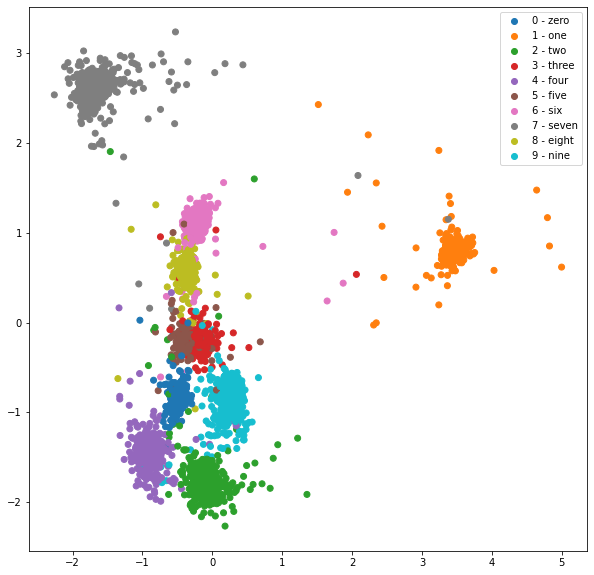

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)